Sketch for prediction of SalesAmount
===

# Setup

In [1]:
##### loads a GPU-accelerated version of pandas, disable if this makes any problems!!

%load_ext cudf.pandas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, GridSearchCV, learning_curve, LearningCurveDisplay
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor

from os import path

# Loading Data

In [3]:
### Load less data for now to try and avoid crashes
skipratio = 0.8 # elements to skip

skipsize = int(3406088 * skipratio)
skipindices = np.random.choice(np.arange(1,3406088), (skipsize), replace = False)
skipindices

array([2751803,  692868, 2509209, ..., 2517122,  296619, 2267523])

In [4]:
### For now, let's work with the dataset prepared by Nishi
data = pd.read_csv("../merged_data/data_ml_merged.csv", header = 0, skiprows = skipindices)

data.set_index(['SalesKey'], inplace=True)
data['DateKey'] = pd.to_datetime(data['DateKey'], infer_datetime_format=True)

print(data.shape)
data.head()

(681219, 40)


DateKey  channelKey  StoreKey  ProductKey  PromotionKey  UnitCost  \
SalesKey                                                                        
3        2008-01-24           1       156        1175            11    209.03   
5        2008-01-22           2       306        1133            10    144.52   
8        2008-04-10           2       307         138            15    229.93   
9        2008-07-14           2       199        1731            12     33.32   
25       2007-06-06           1       108        2351             1    183.94   

          UnitPrice  SalesQuantity  ReturnQuantity  ReturnAmount  ...  \
SalesKey                                                          ...   
3            410.00              9               0           0.0  ...   
5            436.20             24               0           0.0  ...   
8            499.99              9               0           0.0  ...   
9             72.45             24               0           0.0  ...   
25           399.99             10               0           0.0  ...   

          ProductCategoryKey  GeographyKey  StoreType  EmployeeCount  \
SalesKey                                                               
3                        4.0           449      Store             26   
5                        4.0           586     Online              7   
8                        2.0           710     Online              8   
9                        NaN           800     Online            325   
25                       8.0           860      Store             17   

          SellingAreaSize  GeographyType  ContinentName   CityName  \
SalesKey                                                             
3                     680           City         Europe  Cambridge   
5                    1000           City         Europe     Berlin   
8                   93800           City           Asia    Beijing   
9                     500           City  North America   Bethesda   
25                    460           City  North America   Lakeland   

         StateProvinceName RegionCountryName  
SalesKey                                      
3                  England    United Kingdom  
5                   Berlin           Germany  
8                  Beijing             China  
9                 Maryland     United States  
25                 Florida     United States  

[5 rows x 40 columns]

In [5]:
data.CalendarQuarterLabel.unique()

array(['Q1', 'Q2', 'Q3', 'Q4'], dtype=object)

In [6]:
data.DateKey.min

<bound method Series.min of SalesKey
3         2008-01-24
5         2008-01-22
8         2008-04-10
9         2008-07-14
25        2007-06-06
             ...    
3406072   2008-11-02
3406074   2009-09-29
3406085   2007-10-09
3406088   2007-02-04
3406089   2009-08-05
Name: DateKey, Length: 681219, dtype: datetime64[ns]>

In [7]:
data.columns

Index(['DateKey', 'channelKey', 'StoreKey', 'ProductKey', 'PromotionKey',
       'UnitCost', 'UnitPrice', 'SalesQuantity', 'ReturnQuantity',
       'ReturnAmount', 'DiscountQuantity', 'DiscountAmount', 'TotalCost',
       'SalesAmount', 'DiscountPercent', 'CalendarYear',
       'CalendarQuarterLabel', 'CalendarWeekLabel', 'IsWorkDay', 'IsHoliday',
       'MonthNumber', 'CalendarDayOfWeekNumber', 'ProductSubcategoryKey',
       'BrandName', 'ClassID', 'StyleID', 'ColorID', 'Weight',
       'WeightUnitMeasureID', 'StockTypeID', 'ProductCategoryKey',
       'GeographyKey', 'StoreType', 'EmployeeCount', 'SellingAreaSize',
       'GeographyType', 'ContinentName', 'CityName', 'StateProvinceName',
       'RegionCountryName'],
      dtype='object')

# Pre-processing

## Transform select features (i.e., unify weight feature with WeightUnitMeasureID information)

## Scaling and Encoding of select scales

In [9]:
##### Dummy preprocessing
preprocessor = make_column_transformer([RobustScaler(), make_column_selector(dtype_include = "number")])

# Only focus on numeric columns for now
data = data.dropna()
data = data.select_dtypes(include='number')

#####

X = data.drop(columns = ["SalesAmount"])
y = data["SalesAmount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

X_proc = preprocessor.fit_transform(X)

(300587, 26) (128823, 26) (184034, 26) (300587,) (128823,) (184034,)


/home/kai/.pyenv/versions/3.10.6/envs/sales-ninja/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/home/kai/.pyenv/versions/3.10.6/envs/sales-ninja/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


## *(moved to timeseries_mvp)* Seasonal data - aggregating by DateKey

# Models

## Ensemble methods: Decision Tree, XGBoost

### Decision Tree

[0.99483941 0.99822005 0.99794419 0.97914885 0.98580477]


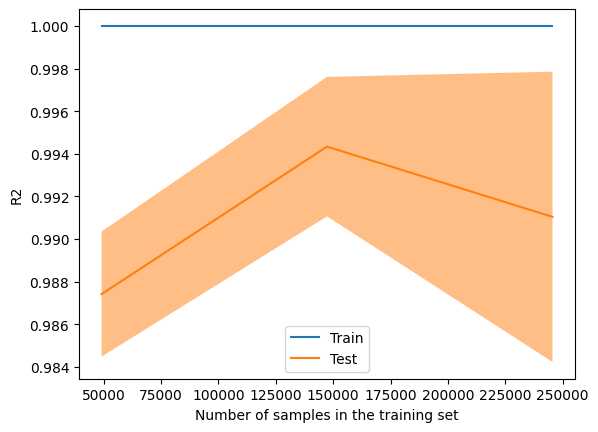

In [12]:
tree = DecisionTreeRegressor()

cv_score = cross_val_score(tree, X_train_proc, y_train, scoring = "r2", cv=5, n_jobs = -1)
print(cv_score)

LearningCurveDisplay.from_estimator(tree, X_proc, y, train_sizes = [0.1, 0.3, 0.5], scoring = "r2", cv=5, n_jobs = -1) 

### Random Forest

In [31]:
forest = RandomForestRegressor(n_estimators=10)

cv_score = cross_val_score(forest, X_train_proc, y_train, scoring = "r2", cv=5, n_jobs = -1)
cv_score

array([0.99833576, 0.99081077, 0.99842768, 0.99843371, 0.99896083])

### Bagging Regressor

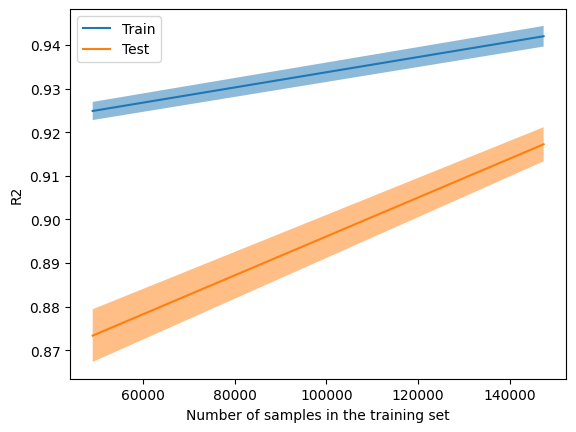

In [14]:
kneighbors = KNeighborsRegressor(n_neighbors = 5)
bagged_kn = BaggingRegressor(kneighbors, n_estimators = 3)

# cv_score = cross_val_score(bagged_kn, X_train_proc, y_train, scoring = "r2", cv=5, n_jobs = -1)
# cv_score

LearningCurveDisplay.from_estimator(bagged_kn, X_proc, y, train_sizes = [0.1, 0.3], scoring = "r2", cv=5, n_jobs = -1) 

### XGBoost

In [23]:
# xgb_cpu = XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.1)

In [21]:
xgb = XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.1, device = "cuda")

In [12]:
# cv_score = cross_val_score(bagged_kn, X_train_proc, y_train, scoring = "r2", cv=5, n_jobs = -1)
# cv_score

In [24]:
# xgb_cpu.fit(X_train, y_train,
#     # evaluate loss at each iteration
#     eval_set=[(X_train, y_train), (X_val, y_val)]#,  
#     # stop iterating when eval loss increases 5 times in a row
#     # early_stopping_rounds=5
# )

[0]	validation_0-rmse:4864.75613	validation_1-rmse:4790.70907
[1]	validation_0-rmse:4389.16731	validation_1-rmse:4325.74279
[2]	validation_0-rmse:3960.58828	validation_1-rmse:3907.12950
[3]	validation_0-rmse:3574.90610	validation_1-rmse:3529.45795
[4]	validation_0-rmse:3227.26942	validation_1-rmse:3189.72687
[5]	validation_0-rmse:2914.36248	validation_1-rmse:2884.86118
[6]	validation_0-rmse:2631.97920	validation_1-rmse:2610.34740
[7]	validation_0-rmse:2377.87631	validation_1-rmse:2363.56055
[8]	validation_0-rmse:2149.12617	validation_1-rmse:2142.33033
[9]	validation_0-rmse:1943.09642	validation_1-rmse:1942.74726
[10]	validation_0-rmse:1757.17966	validation_1-rmse:1761.52191
[11]	validation_0-rmse:1590.03178	validation_1-rmse:1599.57127
[12]	validation_0-rmse:1439.28795	validation_1-rmse:1454.02212
[13]	validation_0-rmse:1303.28350	validation_1-rmse:1322.68700
[14]	validation_0-rmse:1181.11602	validation_1-rmse:1205.94603
[15]	validation_0-rmse:1070.46006	validation_1-rmse:1099.97204
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [22]:
xgb.fit(X_train, y_train,
    # evaluate loss at each iteration
    eval_set=[(X_train, y_train), (X_val, y_val)]#,  
    # stop iterating when eval loss increases 5 times in a row
    # early_stopping_rounds=5
)

[0]	validation_0-rmse:4864.75613	validation_1-rmse:4790.70907
[1]	validation_0-rmse:4389.16730	validation_1-rmse:4325.74389
[2]	validation_0-rmse:3960.58826	validation_1-rmse:3907.13059
[3]	validation_0-rmse:3574.90608	validation_1-rmse:3529.45904
[4]	validation_0-rmse:3227.26939	validation_1-rmse:3189.72797
[5]	validation_0-rmse:2914.36143	validation_1-rmse:2884.86388
[6]	validation_0-rmse:2631.97842	validation_1-rmse:2610.35022
[7]	validation_0-rmse:2377.87564	validation_1-rmse:2363.55854
[8]	validation_0-rmse:2149.12576	validation_1-rmse:2142.32900
[9]	validation_0-rmse:1943.09573	validation_1-rmse:1942.74632
[10]	validation_0-rmse:1757.17874	validation_1-rmse:1761.52189
[11]	validation_0-rmse:1590.03146	validation_1-rmse:1599.56860
[12]	validation_0-rmse:1439.28760	validation_1-rmse:1454.01887
[13]	validation_0-rmse:1303.28418	validation_1-rmse:1322.68953
[14]	validation_0-rmse:1181.11645	validation_1-rmse:1205.94500
[15]	validation_0-rmse:1070.45987	validation_1-rmse:1099.97317
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

#### Scoring the XGBoost model

In [26]:
y_pred = xgb.predict(X_val)
y_pred

array([13113.919  ,   503.5569 ,  5305.417  , ...,  1433.9236 ,
        4945.7715 ,   194.11377], dtype=float32)

In [14]:
# xgb_cpu.predict(X_val)

In [27]:
xgb.score(X_val, y_val)

0.9974041195355453

In [28]:
xgb.score(X_test, y_test)

0.9932577613020622

In [17]:
mean_squared_error(y_val, y_pred)

73149.76217720877

In [18]:
np.sqrt(mean_squared_error(y_val, y_pred))

270.46212706626557

In [19]:
mean_absolute_error(y_val, y_pred)

27.207790506690255

In [20]:
y_test.head()

SalesKey
2834903    6487.000
888461      527.824
1913366      54.905
1221603    2539.873
1308673    6320.000
Name: SalesAmount, dtype: float64

#### Looks pretty good! The model's SalesAmount predictions are on average off by only 27.5 USD!

#### TO DO: Plot observed and predicted data

In [30]:
def plot_prediction(y_pred, X_train, X_test, upper=None, lower=None):
        is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
        # Prepare plot series
        y_pred_series = pd.Series(y_pred, index = X_test.index)
        lower_series = pd.Series(upper, index = X_test.index) if is_confidence_int else None
        upper_series = pd.Series(lower, index = X_test.index) if is_confidence_int else None

        # Plot
        plt.figure(figsize=(10,4), dpi=100)
        plt.plot(X_train["SalesAmount"], label='training', color='black')
        plt.plot(X_test["SalesAmount"], label='actual', color='black', ls='--')
        if is_confidence_int:
            plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
        plt.title('Prediction vs Actual Test Values')
        plt.plot(y_pred_series, label='prediction', color='orange')
        plt.legend(loc='upper left', fontsize=8);

In [31]:
plot_prediction(y_pred, X_train, X_test)

ValueError: Length of values (128823) does not match length of index (184034)